![](https://raw.githubusercontent.com/UGS-CS/CSC3009/master/mashead.svg)

# <center>**Team 16**</center>

In [24]:
# import libaries
from google.colab import drive
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

In [25]:
try:
  drive.mount('/content/drive/')
except Exception as e:
    print(f"Error mounting Google Drive: {e}. Please ensure you are running in Google Colab.")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **1. Exploratory data analysis**

In [26]:
# Define paths
DATASET_PATH = "drive/MyDrive/dataset"

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

Starting EDA on dataset at: drive/MyDrive/dataset

## 1. Class Distribution
---
Training Set Counts: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}
Test Set Counts: {'glioma': 120, 'meningioma': 120, 'notumor': 120, 'pituitary': 120}


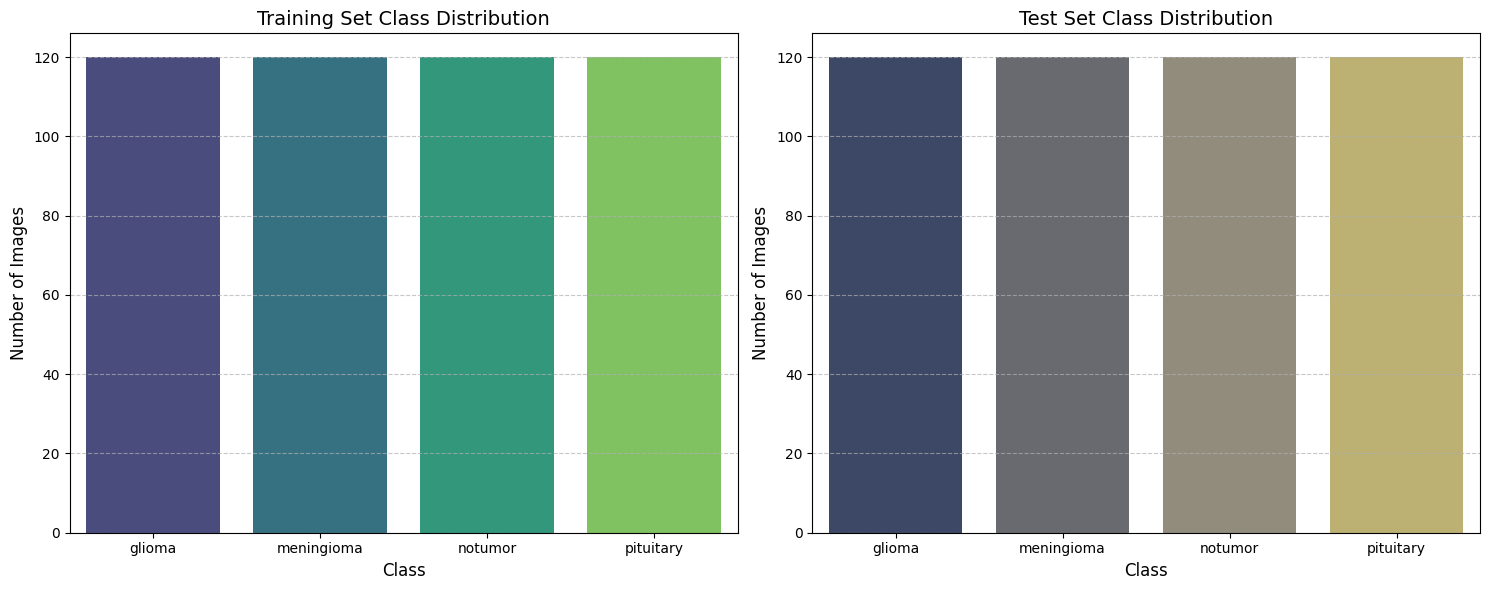


## 2. Image Size Analysis
---
  Processing image sizes for: training/glioma
  Processing image sizes for: training/meningioma
  Processing image sizes for: training/notumor
  Processing image sizes for: training/pituitary
  Processing image sizes for: test/glioma
  Processing image sizes for: test/meningioma
  Processing image sizes for: test/notumor
  Processing image sizes for: test/pituitary

Processed sizes for 960 images.

Image Size Summary (Height x Width):
            Height        Width
count   960.000000   960.000000
mean    452.014583   448.407292
std     124.663835   129.302499
min     168.000000   150.000000
25%     435.250000   414.500000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1019.000000  1149.000000


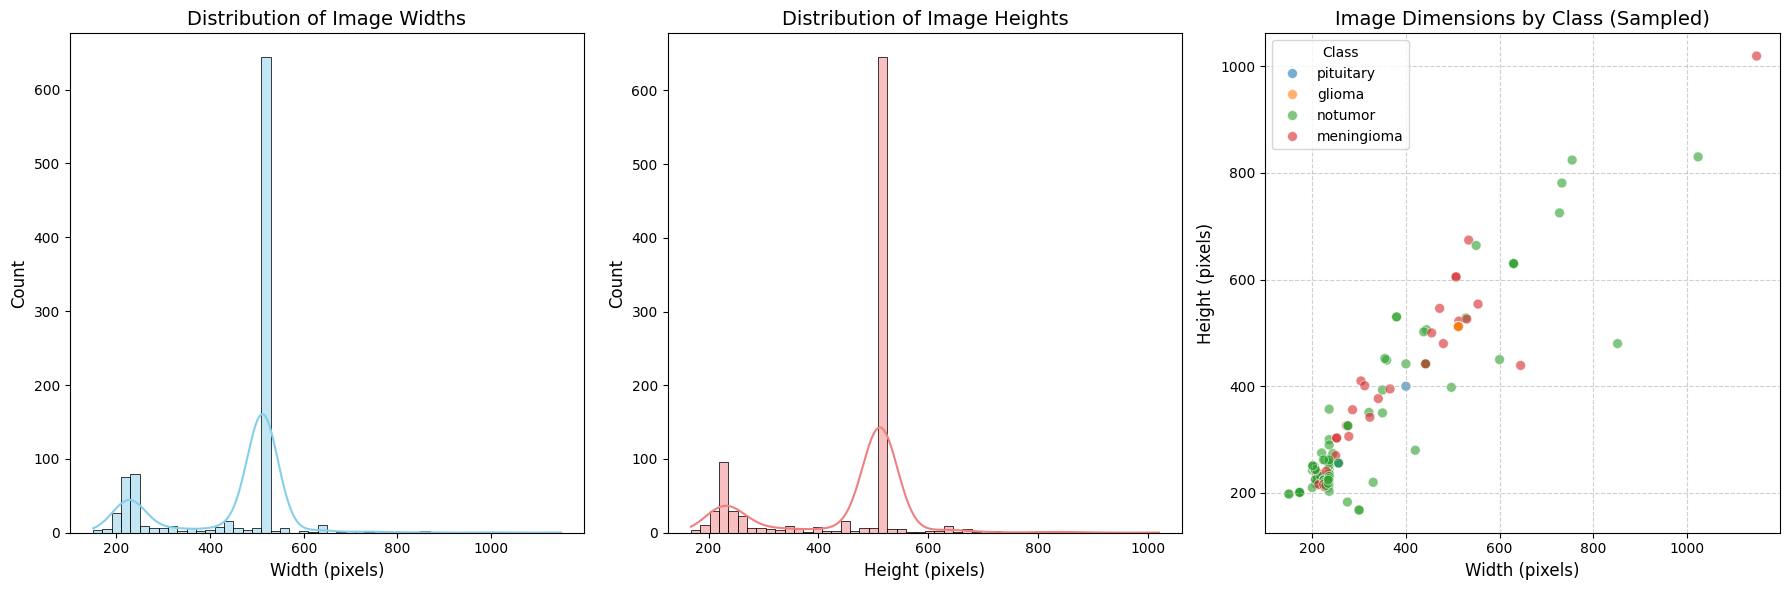

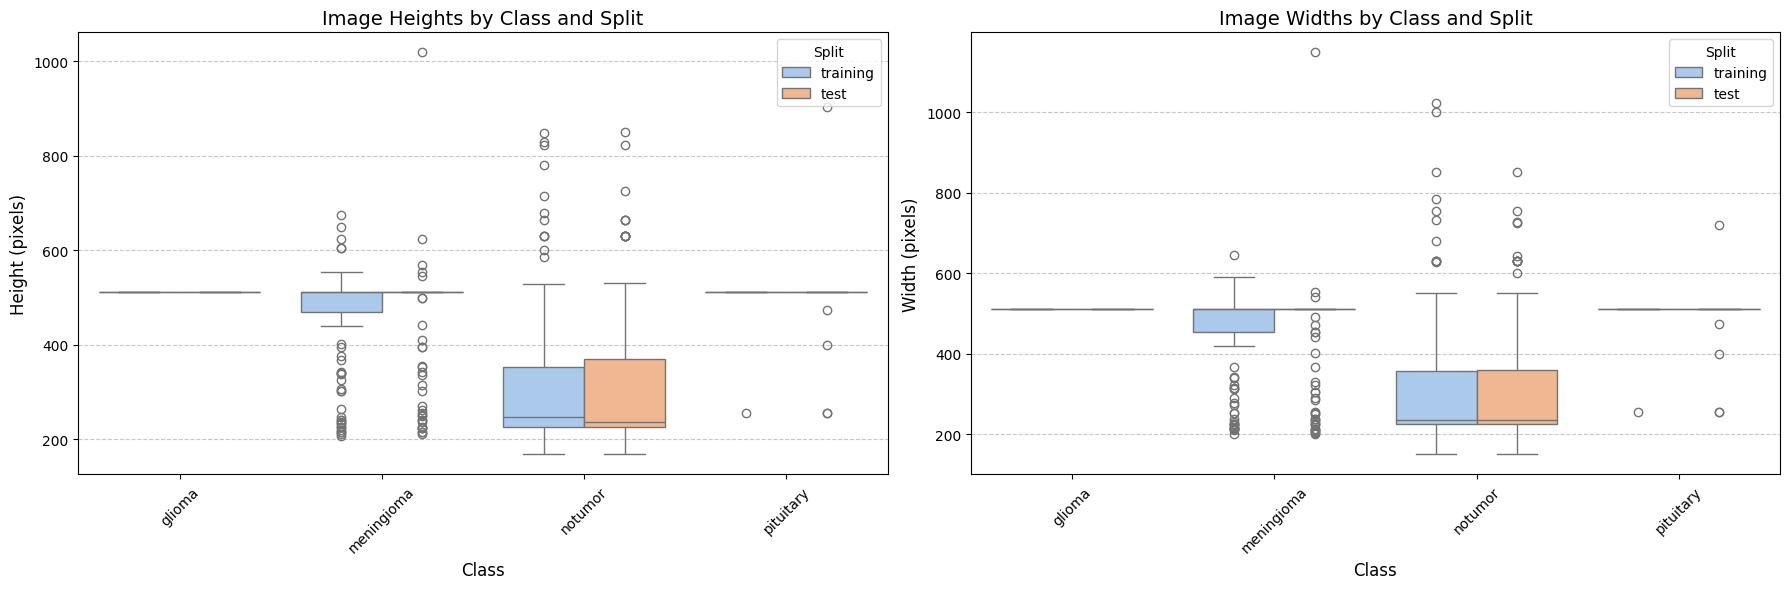


## 3. Image Overlap Check
---
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/glioma
    Found 120 unique IDs for training_glioma
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/meningioma
    Found 120 unique IDs for training_meningioma
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/notumor
    Found 120 unique IDs for training_notumor
  Attempting to list image IDs from: drive/MyDrive/dataset/training/dataset_16/pituitary
    Found 120 unique IDs for training_pituitary
  Attempting to list image IDs from: drive/MyDrive/dataset/test/glioma
    Found 120 unique IDs for test_glioma
  Attempting to list image IDs from: drive/MyDrive/dataset/test/meningioma
    Found 120 unique IDs for test_meningioma
  Attempting to list image IDs from: drive/MyDrive/dataset/test/notumor
    Found 120 unique IDs for test_notumor
  Attempting to list image IDs from: drive/MyDrive/dataset/test/pituitary
    Found

In [27]:
def eda_analysis():
    print(f"Starting EDA on dataset at: {DATASET_PATH}\n")

    # --- 1. Class Distribution ---
    print("## 1. Class Distribution")
    print("---")
    train_counts = {}
    test_counts = {}

    for cls in CLASSES:
        train_path = os.path.join(DATASET_PATH, 'training', 'dataset_16', cls)
        test_path = os.path.join(DATASET_PATH, 'test', cls) # Assuming no 'dataset_16' for test

        if os.path.exists(train_path):
            train_counts[cls] = len(os.listdir(train_path))
        else:
            print(f"Warning: Training directory not found for {cls}: {train_path}")
            train_counts[cls] = 0

        if os.path.exists(test_path):
            test_counts[cls] = len(os.listdir(test_path))
        else:
            print(f"Warning: Test directory not found for {cls}: {test_path}")
            test_counts[cls] = 0

    print("Training Set Counts:", train_counts)
    print("Test Set Counts:", test_counts)

    # Visualization for Class Distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette='viridis', hue=list(train_counts.keys()), legend=False)
    plt.title("Training Set Class Distribution", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), palette='cividis', hue=list(test_counts.keys()), legend=False)
    plt.title("Test Set Class Distribution", fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # --- 2. Image Size Analysis ---
    print("\n## 2. Image Size Analysis")
    print("---")
    size_stats = defaultdict(list) # Stores (height, width) tuples
    total_images_processed = 0

    for split in ['training', 'test']:
        for cls in CLASSES:
            current_image_dir = ""
            if split == 'training':
                current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)
            elif split == 'test':
                # CONFIRM THIS PATH FOR TEST SET:
                current_image_dir = os.path.join(DATASET_PATH, split, cls)
                # If test also has 'dataset_16':
                # current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)

            print(f"  Processing image sizes for: {split}/{cls}")
            if not os.path.exists(current_image_dir):
                print(f"    Warning: Directory not found: {current_image_dir}. Skipping.")
                continue

            for img_name in os.listdir(current_image_dir):
                img_path = os.path.join(current_image_dir, img_name)
                if os.path.isfile(img_path): # Ensure it's a file
                    try:
                        img_raw = tf.io.read_file(img_path)
                        img_tensor = tf.image.decode_image(img_raw, channels=3)

                        if len(img_tensor.shape) >= 2: # Ensure it has at least height and width
                             size_stats[f"{split}_{cls}"].append((img_tensor.shape[0], img_tensor.shape[1]))
                        else:
                            print(f"    Warning: Unexpected shape for image {img_name}: {img_tensor.shape}. Skipping.")

                        total_images_processed += 1
                    except tf.errors.InvalidArgumentError as e:
                        print(f"    Warning: Could not decode image {img_name} in {split}/{cls}. Error: {e}")
                    except Exception as e:
                        print(f"    Warning: Error processing {img_name} in {split}/{cls}. Error: {e}")

    print(f"\nProcessed sizes for {total_images_processed} images.")

    # Analyze and visualize sizes
    all_widths = []
    all_heights = []

    # Convert size stats to a DataFrame for easier plotting
    size_df_data = []
    for key, sizes_list in size_stats.items():
        split_name, class_name = key.split('_')
        for h, w in sizes_list:
            size_df_data.append({'Split': split_name, 'Class': class_name, 'Height': h, 'Width': w})
            all_widths.append(w)
            all_heights.append(h)

    if size_df_data:
        size_df = pd.DataFrame(size_df_data)

        print("\nImage Size Summary (Height x Width):")
        print(size_df[['Height', 'Width']].describe())

        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        sns.histplot(all_widths, bins=50, kde=True, color='skyblue')
        plt.title("Distribution of Image Widths", fontsize=14)
        plt.xlabel("Width (pixels)", fontsize=12)
        plt.ylabel("Count", fontsize=12)

        plt.subplot(1, 3, 2)
        sns.histplot(all_heights, bins=50, kde=True, color='lightcoral')
        plt.title("Distribution of Image Heights", fontsize=14)
        plt.xlabel("Height (pixels)", fontsize=12)
        plt.ylabel("Count", fontsize=12)

        plt.subplot(1, 3, 3)
        # Sample for scatter plot if too many points
        sample_df = size_df.sample(min(500, len(size_df))) if len(size_df) > 500 else size_df
        sns.scatterplot(data=sample_df, x='Width', y='Height', hue='Class', alpha=0.6, s=50, palette='tab10')
        plt.title("Image Dimensions by Class (Sampled)", fontsize=14)
        plt.xlabel("Width (pixels)", fontsize=12)
        plt.ylabel("Height (pixels)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Box plot for sizes by class
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=size_df, x='Class', y='Height', hue='Split', palette='pastel')
        plt.title("Image Heights by Class and Split", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Height (pixels)", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.subplot(1, 2, 2)
        sns.boxplot(data=size_df, x='Class', y='Width', hue='Split', palette='pastel')
        plt.title("Image Widths by Class and Split", fontsize=14)
        plt.xlabel("Class", fontsize=12)
        plt.ylabel("Width (pixels)", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    else:
        print("No image size data collected. Ensure paths are correct and images are present.")


    # --- 3. Image Overlap Check ---
    print("\n## 3. Image Overlap Check")
    print("---")
    image_ids = {} # Stores sets of IDs for each split_class combination

    for split in ['training', 'test']:
        for cls in CLASSES:
            current_image_dir = ""
            if split == 'training':
                current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)
            elif split == 'test':
                # CONFIRM THIS PATH FOR TEST SET:
                current_image_dir = os.path.join(DATASET_PATH, split, cls)
                # If test also has 'dataset_16':
                # current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)

            print(f"  Attempting to list image IDs from: {current_image_dir}")

            if os.path.exists(current_image_dir):
                ids = set()
                try:
                    for f in os.listdir(current_image_dir):
                        file_path = os.path.join(current_image_dir, f)
                        if os.path.isfile(file_path):
                            # CORRECTED LINE: Use the full filename without extension as the ID
                            ids.add(os.path.splitext(f)[0])
                except Exception as e:
                    print(f"    Error listing files in {current_image_dir}: {e}")
                    ids = set()

                image_ids[f"{split}_{cls}"] = ids
                print(f"    Found {len(ids)} unique IDs for {split}_{cls}")
            else:
                print(f"    Warning: Directory not found for image ID check: {current_image_dir}. Skipping {split}/{cls}.")
                image_ids[f"{split}_{cls}"] = set()


    # --- 4. Missing or Corrupted Image Check ---
    print("\n## 4. Missing or Corrupted Image Check")
    print("---")
    missing_or_corrupted = defaultdict(list)

    for split in ['training', 'test']:
        for cls in CLASSES:
            current_image_dir = ""
            if split == 'training':
                current_image_dir = os.path.join(DATASET_PATH, split, 'dataset_16', cls)
            elif split == 'test':
                current_image_dir = os.path.join(DATASET_PATH, split, cls)

            if not os.path.exists(current_image_dir):
                print(f"  Skipping {split}/{cls} - directory does not exist.")
                continue

            print(f"  Checking images in: {split}/{cls}")
            for img_name in os.listdir(current_image_dir):
                img_path = os.path.join(current_image_dir, img_name)
                if os.path.isfile(img_path):
                    try:
                        img_raw = tf.io.read_file(img_path)
                        _ = tf.image.decode_image(img_raw, channels=3)
                    except Exception as e:
                        missing_or_corrupted[f"{split}_{cls}"].append((img_name, str(e)))

    # Report corrupted images
    total_missing = sum(len(v) for v in missing_or_corrupted.values())
    print(f"\nTotal missing or corrupted images: {total_missing}")

    if total_missing > 0:
        for key, problems in missing_or_corrupted.items():
            print(f"\n  {key} - {len(problems)} issues")
            for filename, error in problems[:5]:  # Show up to 5 per class
                print(f"    {filename}: {error}")
        print("\n  **WARNING: Some images are unreadable or corrupted. Consider removing or replacing them.**")
    else:
        print("  ✅ All images are readable. No missing or corrupted files detected.")


    # --- Compare Training and Test Sets for Overall Overlap ---
    print("\n--- Comparing Training and Test Sets for Overall Overlap ---")

    all_train_ids = set()
    for cls in CLASSES:
        all_train_ids.update(image_ids.get(f"training_{cls}", set()))

    all_test_ids = set()
    for cls in CLASSES:
        all_test_ids.update(image_ids.get(f"test_{cls}", set()))

    overall_overlap = all_train_ids.intersection(all_test_ids)

    print(f"Total unique IDs in Training Set: {len(all_train_ids)}")
    print(f"Total unique IDs in Test Set:     {len(all_test_ids)}")
    print(f"Total unique IDs overlapping between Training and Test Sets: {len(overall_overlap)}")

    if len(overall_overlap) > 0:
        print(f"  Example overlapping IDs: {list(overall_overlap)[:5]} (showing up to 5 examples)")
        print("\n  **WARNING: OVERLAP DETECTED!** This means some images (or their direct variations) are present in both training and test sets.")
        print("  This can lead to **overly optimistic model performance metrics** during evaluation.")
        print("  Consider re-splitting your dataset to ensure strict separation between training and test data if this is unintentional.")
    else:
        print("  No overlap detected between training and test sets. This is ideal for robust model evaluation.")

    print("\nEDA Complete!")

# Execute the analysis
eda_analysis()

Found 480 files belonging to 4 classes.
Found 480 files belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

🔍 Training Batch Shape:
Images shape: (32, 224, 224, 3)
Labels shape: (32,)

First Image Shape: (224, 224, 3)
First Image Pixel Values (as uint8):
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Class index of first image: 0


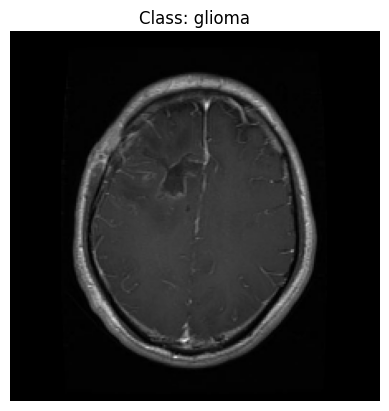

In [28]:
# Load datasets
# Define paths
# Correct the DATASET_PATH to point to the root of your dataset on Google Drive
DATASET_PATH = "drive/MyDrive/dataset"

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Use os.path.join with the DATASET_PATH variable
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "training", "dataset_16"),
    image_size=(224, 224),   # You can change this size
    batch_size=32,
    shuffle=False
)

# Update the test path as well to use DATASET_PATH
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "test"), # Assuming the test data is directly under 'test'
    image_size=(224, 224),
    batch_size=32
)

# View class names
print("Class names:", train_ds.class_names)

# Inspect one batch from training dataset
for images, labels in train_ds.take(1):
    print("\n🔍 Training Batch Shape:")
    print("Images shape:", images.shape)  # (batch_size, height, width, channels)
    print("Labels shape:", labels.shape)

    # Get first image
    image = images[0].numpy()
    label = labels[0].numpy()

    print("\nFirst Image Shape:", image.shape)
    print("First Image Pixel Values (as uint8):")
    print(image.astype(np.uint8))  # You can also use np.round(image) for cleaner output
    print("Class index of first image:", label)
    break


# Display the first image
plt.imshow(image.astype("uint8"))  # Convert to uint8 for proper color rendering
plt.title(f"Class: {train_ds.class_names[label]}")
plt.axis("off")
plt.show()



Check images with no pixel variation (potentially blank)

In [29]:
def check_blank_images(dataset):
    blank_count = 0
    total = 0
    for image_batch, label_batch in dataset:
        for img in image_batch:
            total += 1
            if np.std(img.numpy()) == 0:  # All pixels same
                blank_count += 1
    print(f"Blank images: {blank_count}/{total}")
check_blank_images(train_ds)

Blank images: 0/480


## **2. Data preparation and pre-processing**

### Create Metadata File

In [30]:
def prepare_metadata_table(dataset_dir, class_names, id_delimiter='_', id_parts=2, image_extensions={'.jpg', '.jpeg', '.png'}):
    """
    Prepares metadata table with renamed class labels.

    Args:
        dataset_dir (str): Path to dataset folder
        class_names (list): Target class names, used in order
        id_delimiter (str): Delimiter for parsing ID from filename
        id_parts (int): Number of parts to keep from split filename
        image_extensions (set): Acceptable image file extensions

    Returns:
        pd.DataFrame: Metadata table with columns: path, label, id
    """
    data = []
    subfolders = sorted(os.listdir(dataset_dir))  # Assumes order matches class_names
    class_map = {orig: new for orig, new in zip(subfolders, class_names)}

    for folder in subfolders:
        folder_path = os.path.join(dataset_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = class_map.get(folder)
        if label is None:
            continue

        for filename in os.listdir(folder_path):
            ext = os.path.splitext(filename)[1].lower()
            if ext not in image_extensions:
                continue

            full_path = os.path.join(folder_path, filename)

            name_wo_ext = os.path.splitext(filename)[0]
            id_parts_split = name_wo_ext.split(id_delimiter)[:id_parts]
            unique_id = id_delimiter.join(id_parts_split)

            data.append({
                'path': full_path,
                'label': label,
                'id': unique_id
            })

    df = pd.DataFrame(data)
    print(f"✅ Metadata table created with {len(df)} entries.")
    print(df.head())
    return df


In [31]:
DATASET_PATH_TRAIN = "drive/MyDrive/dataset/training/dataset_16"
DATASET_PATH_TEST = "drive/MyDrive/dataset/test"  # Corrected the directory name from 'testing' to 'test'
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Assuming folder names are already correct (e.g., "glioma", "pituitary"), no mapping is needed
train_df = prepare_metadata_table(DATASET_PATH_TRAIN, CLASSES)
test_df = prepare_metadata_table(DATASET_PATH_TEST, CLASSES)

✅ Metadata table created with 480 entries.
                                                path   label          id
0  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Tr-gl_0109
1  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Te-gl_0129
2  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Tr-gl_0120
3  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Te-gl_0079
4  drive/MyDrive/dataset/training/dataset_16/glio...  glioma  Te-gl_0178
✅ Metadata table created with 480 entries.
                                               path   label          id
0  drive/MyDrive/dataset/test/glioma/Te-gl_0170.jpg  glioma  Te-gl_0170
1  drive/MyDrive/dataset/test/glioma/Te-gl_0167.jpg  glioma  Te-gl_0167
2  drive/MyDrive/dataset/test/glioma/Tr-gl_0107.jpg  glioma  Tr-gl_0107
3  drive/MyDrive/dataset/test/glioma/Tr-gl_0277.jpg  glioma  Tr-gl_0277
4  drive/MyDrive/dataset/test/glioma/Tr-gl_0061.jpg  glioma  Tr-gl_0061


### Check the number of duplicates IDs in both the training and testing datatsets

In [32]:
# Correct cross-dataset overlap check
train_ids = set(train_df['id'])
test_ids = set(test_df['id'])

overlap_ids = train_ids.intersection(test_ids)
print(f"⚠️ Correct overlapping IDs between train and test: {len(overlap_ids)}")
if overlap_ids:
    print("Examples of overlapping IDs:", list(overlap_ids)[:5])

# Optional: show full rows for these overlapping IDs
if overlap_ids:
    overlap_df_train = train_df[train_df['id'].isin(overlap_ids)]
    overlap_df_test = test_df[test_df['id'].isin(overlap_ids)]
    print("\n🔁 In Training Set:")
    print(overlap_df_train[['id', 'path', 'label']].sort_values('id'))
    print("\n🔁 In Testing Set:")
    print(overlap_df_test[['id', 'path', 'label']].sort_values('id'))


⚠️ Correct overlapping IDs between train and test: 75
Examples of overlapping IDs: ['Te-me_0033', 'Te-me_0012', 'Tr-me_0159', 'Tr-me_0325', 'Te-me_0127']

🔁 In Training Set:
             id                                               path      label
21   Te-gl_0064  drive/MyDrive/dataset/training/dataset_16/glio...     glioma
45   Te-gl_0112  drive/MyDrive/dataset/training/dataset_16/glio...     glioma
1    Te-gl_0129  drive/MyDrive/dataset/training/dataset_16/glio...     glioma
10   Te-gl_0134  drive/MyDrive/dataset/training/dataset_16/glio...     glioma
57   Te-gl_0167  drive/MyDrive/dataset/training/dataset_16/glio...     glioma
..          ...                                                ...        ...
384  Tr-pi_0213  drive/MyDrive/dataset/training/dataset_16/pitu...  pituitary
415  Tr-pi_0227  drive/MyDrive/dataset/training/dataset_16/pitu...  pituitary
380  Tr-pi_0342  drive/MyDrive/dataset/training/dataset_16/pitu...  pituitary
387  Tr-pi_0386  drive/MyDrive/dataset/trainin

### Remove duplicate IDs in testing dataset

In [33]:
# Get sets of IDs in train and test
train_ids = set(train_df['id'])
test_ids = set(test_df['id'])

# Find overlap IDs
overlap_ids = train_ids.intersection(test_ids)
print(f"Overlapping IDs count: {len(overlap_ids)}")

# Drop overlapping IDs from test set
test_df_clean = test_df[~test_df['id'].isin(overlap_ids)].reset_index(drop=True)

print(f"Original test set size: {len(test_df)}")
print(f"Cleaned test set size (no overlaps): {len(test_df_clean)}")


Overlapping IDs count: 75
Original test set size: 480
Cleaned test set size (no overlaps): 405


### Split Images by Unique IDs

Ensure Class Balance by using GroupKFold or GroupShuffleSplit from scikit-learn

In [34]:
# Load metadata table
df = pd.concat([train_df, test_df], ignore_index=True)  # ✅ Combine metadata tables for group-based split

# 80% train, 20% test
splitter = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, test_idx = next(splitter.split(df, groups=df['id'], y=df['label']))

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# Check balance
print("Train label distribution:\n", train_df['label'].value_counts(normalize=True))
print("Test label distribution:\n", test_df['label'].value_counts(normalize=True))

# Check no overlap
print("Overlap:", set(train_df['id']).intersection(set(test_df['id'])))  # Should be empty


Train label distribution:
 label
notumor       0.265201
pituitary     0.252264
glioma        0.249677
meningioma    0.232859
Name: proportion, dtype: float64
Test label distribution:
 label
meningioma    0.320856
glioma        0.251337
pituitary     0.240642
notumor       0.187166
Name: proportion, dtype: float64
Overlap: set()


In [35]:
print("Train dataset shape:", train_df.shape)  # (number_of_rows, number_of_columns)
print("Test dataset shape:", test_df.shape)


Train dataset shape: (773, 3)
Test dataset shape: (187, 3)


### Check the class split

In [36]:
# Count samples per class in training set
print("Training set class distribution:")
print(train_df['label'].value_counts())

# Count samples per class in test set
print("\nTest set class distribution:")
print(test_df['label'].value_counts())


Training set class distribution:
label
notumor       205
pituitary     195
glioma        193
meningioma    180
Name: count, dtype: int64

Test set class distribution:
label
meningioma    60
glioma        47
pituitary     45
notumor       35
Name: count, dtype: int64


###Standardize Image Sizes
To have all images same size and pixels to ensure consistency in the data.

In [37]:
# --- Configuration for Image Processing ---
IMG_HEIGHT = 224 # Target height for all images
IMG_WIDTH = 224  # Target width for all images
BATCH_SIZE = 32  # Number of images per batch

# Map class names to integer labels for TensorFlow
class_to_label_map = {name: i for i, name in enumerate(CLASSES)}

# --- 1. Image Loading Function ---
def load_image_and_label(image_path, label):
    """
    Reads an image file, decodes it, and maps the string label to an integer.

    Args:
        image_path (tf.Tensor): The path to the image file.
        label (tf.Tensor): The string label of the image.

    Returns:
        tuple: A tuple containing the decoded image tensor and its integer label.
    """
    image_raw = tf.io.read_file(image_path)
    # Decode the image. channels=3 for RGB images.
    # The image will be decoded as a tf.uint8 tensor.
    image = tf.image.decode_image(image_raw, channels=3)
    # Ensure image has 3 channels if it's grayscale but represented as 1 channel
    image = tf.image.convert_image_dtype(image, tf.float32) # Convert to float32 for consistency
    image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method=tf.image.ResizeMethod.BILINEAR, antialias=True) # Ensure consistent size after potential decode issues
    image = tf.cast(image * 255, dtype=tf.uint8) # Convert back to uint8 for augmentation

    # Map string label to integer
    numeric_label = tf.py_function(lambda x: class_to_label_map[x.numpy().decode('utf-8')], [label], tf.int32)
    numeric_label.set_shape([]) # Set shape to scalar

    return image, numeric_label

### Data Augmentation
Apply data augmentation to the training set to increase dataset diversity and prevent overfitting. This is especially important for medical imaging tasks like brain tumor classification, where data may be limited.

In [38]:
# --- 2. Image Augmentation Function (for training data) ---
def augment_image(image, label):
    """
    Applies random data augmentation techniques to an image.
    These transformations help the model generalize better by seeing varied versions of training images.

    Args:
        image (tf.Tensor): The image tensor (tf.uint8, [0, 255]).
        label (tf.Tensor): The label of the image.

    Returns:
        tuple: A tuple containing the augmented image tensor and its label.
    """
    # Cast to float32 before augmentation ops that expect it
    image = tf.cast(image, tf.float32)

    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip (less common for medical images, but can be useful)
    # image = tf.image.random_flip_up_down(image) # Uncomment if vertical flips are appropriate

    # Random rotation by 0, 90, 180, or 270 degrees
    # `tf.image.rot90` requires k (number of 90-degree rotations) to be integer
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    # Random brightness adjustment
    # max_delta is a percentage of the image range (e.g., 0.2 means 20% max change)
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast adjustment
    # lower and upper are factors by which to multiply the contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation adjustment (for color images)
    # image = tf.image.random_saturation(image, lower=0.8, upper=1.2) # Uncomment if useful

    # Random crop (if images are larger than target size, then resize after crop)
    # if tf.shape(image)[0] > IMG_HEIGHT and tf.shape(image)[1] > IMG_WIDTH:
    #     image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    # else:
    #     image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH)) # Ensure consistent size


    # Ensure the image is back to the expected shape after augmentation, particularly for
    # random crop if implemented. Most `tf.image` ops preserve height/width.
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    return image, label

In [39]:
# --- 3. Preprocessing Function (Resize and Normalize) ---
def preprocess_image(image, label):
    """
    Resizes the image to the target dimensions and normalizes pixel values
    from [0, 255] to [0, 1].

    Args:
        image (tf.Tensor): The image tensor (tf.float32 or tf.uint8).
        label (tf.Tensor): The label of the image.

    Returns:
        tuple: A tuple containing the preprocessed image tensor (tf.float32, [0, 1])
               and its label.
    """
    # Resize image to target dimensions
    # Use 'BILINEAR' for interpolation, antialias=True for better quality downsampling
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH), method=tf.image.ResizeMethod.BILINEAR, antialias=True)

    # Normalize pixel values to [0, 1]
    # Cast to float32 before division
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [40]:
# --- Create tf.data.Dataset Pipelines ---

print("\n--- Creating TensorFlow Data Pipelines ---")

# Training Dataset
# Convert DataFrame paths and labels to TensorFlow tensors
train_paths = tf.constant(train_df['path'].tolist())
train_labels = tf.constant(train_df['label'].tolist())

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
# Load images and initial label mapping
train_ds = train_ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
# Apply augmentation *only* to the training set
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
# Apply final preprocessing (resize and normalize)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle the training data
train_ds = train_ds.shuffle(buffer_size=len(train_df))
# Batch and prefetch for performance
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Training dataset created with {len(train_df)} images.")

# Testing Dataset
test_paths = tf.constant(test_df['path'].tolist())
test_labels = tf.constant(test_df['label'].tolist())

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
# Load images and initial label mapping
test_ds = test_ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
# Apply only preprocessing (resize and normalize) to the test set
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Batch and prefetch for performance
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Testing dataset created with {len(test_df)} images.")


--- Creating TensorFlow Data Pipelines ---
Training dataset created with 773 images.
Testing dataset created with 187 images.


### Verify Preprocessed Data


--- Verifying Dataset Shapes and Visualizing Augmentations ---

🔍 Preprocessed Training Batch Shape:


Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Image pixel value range: -0.02959291 to 1.0688493


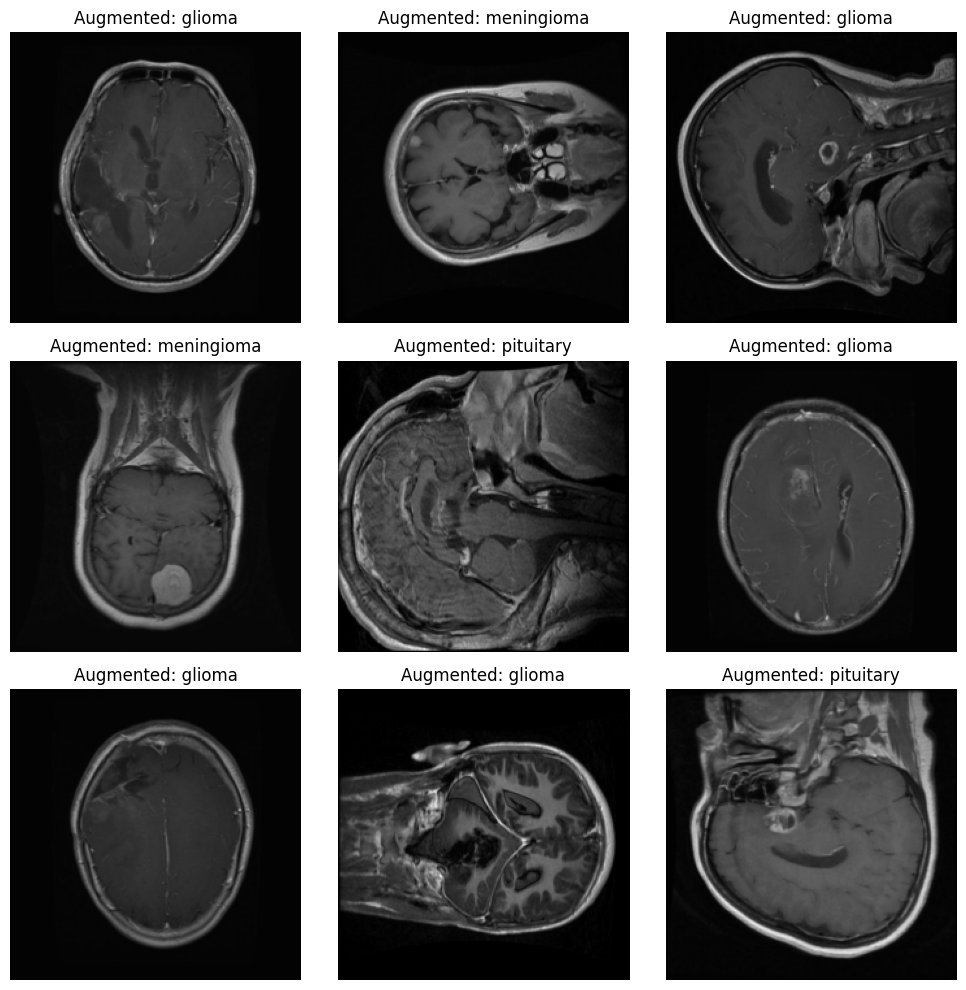


🔍 Preprocessed Testing Batch Shape:
Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Image pixel value range: 0.0 to 1.0

Image preprocessing, normalization, and augmentation complete!


In [41]:
# --- Verify Dataset and Visualize Augmentations ---

print("\n--- Verifying Dataset Shapes and Visualizing Augmentations ---")

# Inspect one batch from the preprocessed training dataset
print("\n🔍 Preprocessed Training Batch Shape:")
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape) # (batch_size, IMG_HEIGHT, IMG_WIDTH, channels)
    print("Labels shape:", labels.shape)
    print("Image pixel value range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())

    # Display some augmented images
    plt.figure(figsize=(10, 10))
    for i in range(min(9, images.shape[0])): # Display up to 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # Images are now [0, 1] float
        # Convert numeric label back to class name for display
        class_name = CLASSES[labels[i].numpy()]
        plt.title(f"Augmented: {class_name}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break # Only take one batch

# Inspect one batch from the preprocessed testing dataset
print("\n🔍 Preprocessed Testing Batch Shape:")
for images, labels in test_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Image pixel value range:", tf.reduce_min(images).numpy(), "to", tf.reduce_max(images).numpy())
    # No need to visualize augmented images for test_ds as it's not augmented.
    # Can display raw test images if desired, similar to initial inspection.
    break

print("\nImage preprocessing, normalization, and augmentation complete!")

#<font color=lightgreen> TESTING ONLY </font>

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weight_dict
)

Epoch 1/10
 8/15 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.3027 - loss: 1.5174